# Conceptular Synthesis Experiment 2: Resynthesis of a kick drum sample

In [2]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
figsize(20,6)

Populating the interactive namespace from numpy and matplotlib


In [3]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [15]:
y, sr = librosa.load("audios/909a_22k.wav", sr=22050)
y = y[20:]
windowSize =200
padding = windowSize - (y.size % windowSize)
y = np.concatenate((y, np.zeros(padding)))
nWindows = int(y.size/windowSize)
print(y.shape, nWindows)

(9600,) 48


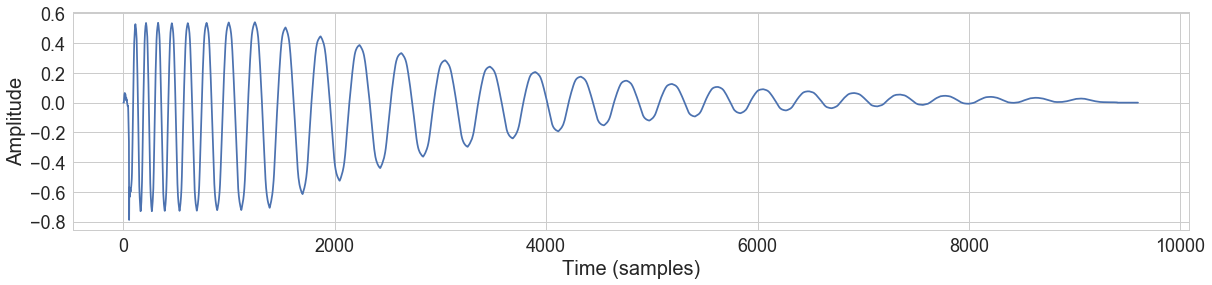

In [16]:
import seaborn as sns
sns.set(style="whitegrid")
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(y)
figsize(20,4)
plt.savefig('/tmp/909.pdf', bbox_inches='tight')

In [17]:
Audio(data=y[:],rate=sr)

In [18]:
#divide out windows
patterns = np.zeros((nWindows, windowSize))
for i in range(nWindows):
    patterns[i] = y[i*windowSize : (i+1) * windowSize]

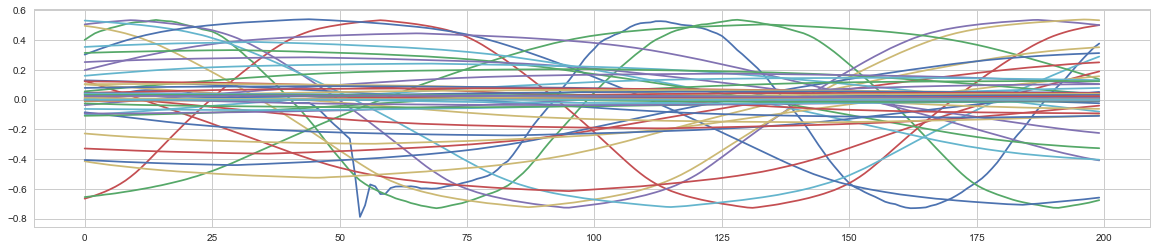

In [19]:
figsize(20,4)
for i in range(int(nWindows)):
# for i in range(int(50)):
    plot(patterns[i])
plt.savefig('/tmp/909Pieces.pdf')    

In [30]:
%%time
#create a random reservoir and load it with patterns using Jaeger's method
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, p['learnLength'] * p['patts'].shape[0]));
    allTrainOldxArgs = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
    allTrainWtargets = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
    allTrainOuts = np.zeros((1, p['learnLength'] * p['patts'].shape[0]));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        storeBegin = i_pattern * p['learnLength']
        storeEnd = (i_pattern * p['learnLength']) + p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs[:,storeBegin : storeEnd ] = xCollector
        allTrainOldxArgs[:,storeBegin : storeEnd ] = xOldCollector
        allTrainOuts[:,storeBegin : storeEnd ] = pCollector
        allTrainWtargets[:,storeBegin : storeEnd ]  = WTargetCollector


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout', 'allTrainOldxArgs','NRMSE_readout', 'absSize_readout')}
    return data

    


    
params = {'N':900, 'NetSR':1.5, 'NetinpScaling':1.2,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':windowSize*4, 'learnLength':windowSize * 4, 'TychonovAlphaReadout':0.001,
          'LR': 0.3,
           'patts':patterns[np.arange(int(3000/windowSize))]
#           'patts':patterns
         }



sampleSize = 10
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_readout'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_readout'], "avg: ", np.mean(nrmses) )



0
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
NRMSE readout:  0.0038140775953257014  :: absSize readout:  0.1344409044496213
NRMSE W:  0.0195203529455063  :: absSize W:  1.6716340167255046
1
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
NRMSE readout:  0.005390557274955421  :: absSize readout:  0.14012706417580192
NRMSE W:  0.021012890834340065  :: absSize W:  1.3212518232793105
2
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
NRMSE readout:  0.004714866548215136  :: absSize readout:  0.1408169882873668
NRMSE W:  0.02181607471650511  :: absSize W:  1.6183817070274409
3
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
NRMSE readout:  0.004505837645012724  :: absSize readout:  0.14476586064780342
NRMSE W:  0.020905960371236088  :: absSize W:  1.5143460458905722
4
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
NRMSE readout:  0.004247316080282558  :: absSize readout:  0.13317107

In [31]:
def computeConceptor(net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros(4, dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(net['p']['N'])))

    C =  U.dot(Snew).dot(U.T);
    Cs[0] = C
    Cs[1] = U
    Cs[2] = diag(Snew)
    Cs[3] = diag(S)

    return Cs


def testConceptor(net, cs, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cs[0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        z_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        x = 0.5 * np.random.randn(net['p']['N'],1) * 0.0
        z = x
        for n in range(recallTestLength + net['p']['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > net['p']['washoutLength']):
                x_CTestPL[:,n-net['p']['washoutLength']] = x.T
                z_CTestPL[:,n-net['p']['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)



In [32]:
%%time
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cs = computeConceptor(loadedNets[bestNetwork], args[0], aperture)
    atten = testConceptor(loadedNets[bestNetwork], cs, windowSize*4)
    return atten

#scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

Pattern:  0
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00187889        initial
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00242091        golden
Pattern:  0
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000181906        golden
Pattern:  0
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000378304        golden
Pattern:  0
Computing conceptor, alpha:  209.5999973242038
    5          209.6  0.000199083        parabolic
Pattern:  0
Computing conceptor, alpha:  236.40131433457697
    6        236.401  0.000181951        parabolic
Pattern:  0
Computing conceptor, alpha:  233.9337410874594
    7        233.934  0.000183789        parabolic
Pattern:  0
Computing conceptor, alpha:  235.25277173030716
    8        235.253  0.000181972        golden
Pattern:  0
Computing conceptor, alpha:  235.73464066500242
    9        235.7

 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0354595        initial
Pattern:  6
Computing conceptor, alpha:  618.0339887498948
    2        618.034    0.0576837        golden
Pattern:  6
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000472435        golden
Pattern:  6
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000103124        golden
Pattern:  6
Computing conceptor, alpha:  188.93202978884995
    5        188.932   0.00020629        parabolic
Pattern:  6
Computing conceptor, alpha:  134.14828951295817
    6        134.148  8.40248e-05        parabolic
Pattern:  6
Computing conceptor, alpha:  82.90820245166924
    7        82.9082  3.54159e-05        golden
Pattern:  6
Computing conceptor, alpha:  64.38300190995407
    8         64.383  2.64547e-05        parabolic
Pattern:  6
Computing conceptor, alpha:  39.79088347810102
    9        39.7909  1.96939e-05        golden
Pattern:  6
Computing concepto

    8         307.69  5.52712e-06        parabolic
Pattern:  11
Computing conceptor, alpha:  307.0234018778839
    9        307.023  5.52712e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  12
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.16574e-05        initial
Pattern:  12
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.36437e-05        golden
Pattern:  12
Computing conceptor, alpha:  236.0679774997897
    3        236.068  1.12226e-05        golden
Pattern:  12
Computing conceptor, alpha:  204.25693848910575
    4        204.257  1.13322e-05        parabolic
Pattern:  12
Computing conceptor, alpha:  267.81412149747007
    5        267.814  1.12417e-05        parabolic
Pattern:  12
Computing conceptor, alpha:  247.21411806875895
    6        247.214  1.12184e-05        parabolic
Pattern:  12

0
Computing conceptor, alpha:  235.73464066500242
0.9577589480340037
1
Computing conceptor, alpha:  999.6002107189987
5.421049149100668
2
Computing conceptor, alpha:  365.6953065530051
0.19690758775868575
3
Computing conceptor, alpha:  137.18251994847694
0.016719480196319903
4
Computing conceptor, alpha:  219.74029762047905
0.019549451439719936
5
Computing conceptor, alpha:  338.88297880038436
0.03237671392159665
6
Computing conceptor, alpha:  41.54713322252014
0.1408751581825217
7
Computing conceptor, alpha:  826.5786302934622
1.5131126192613924
8
Computing conceptor, alpha:  379.7511559773755
0.018215462397606883
9
Computing conceptor, alpha:  197.14326653705115
0.13810515202530088
10
Computing conceptor, alpha:  334.0854213126945
0.19437380108281166
11
Computing conceptor, alpha:  307.3567397700544
0.1916049393633641
12
Computing conceptor, alpha:  245.06673150823767
0.1878452884641379
13
Computing conceptor, alpha:  999.6002107189987
0.28473233428615274
14
Computing conceptor, alph

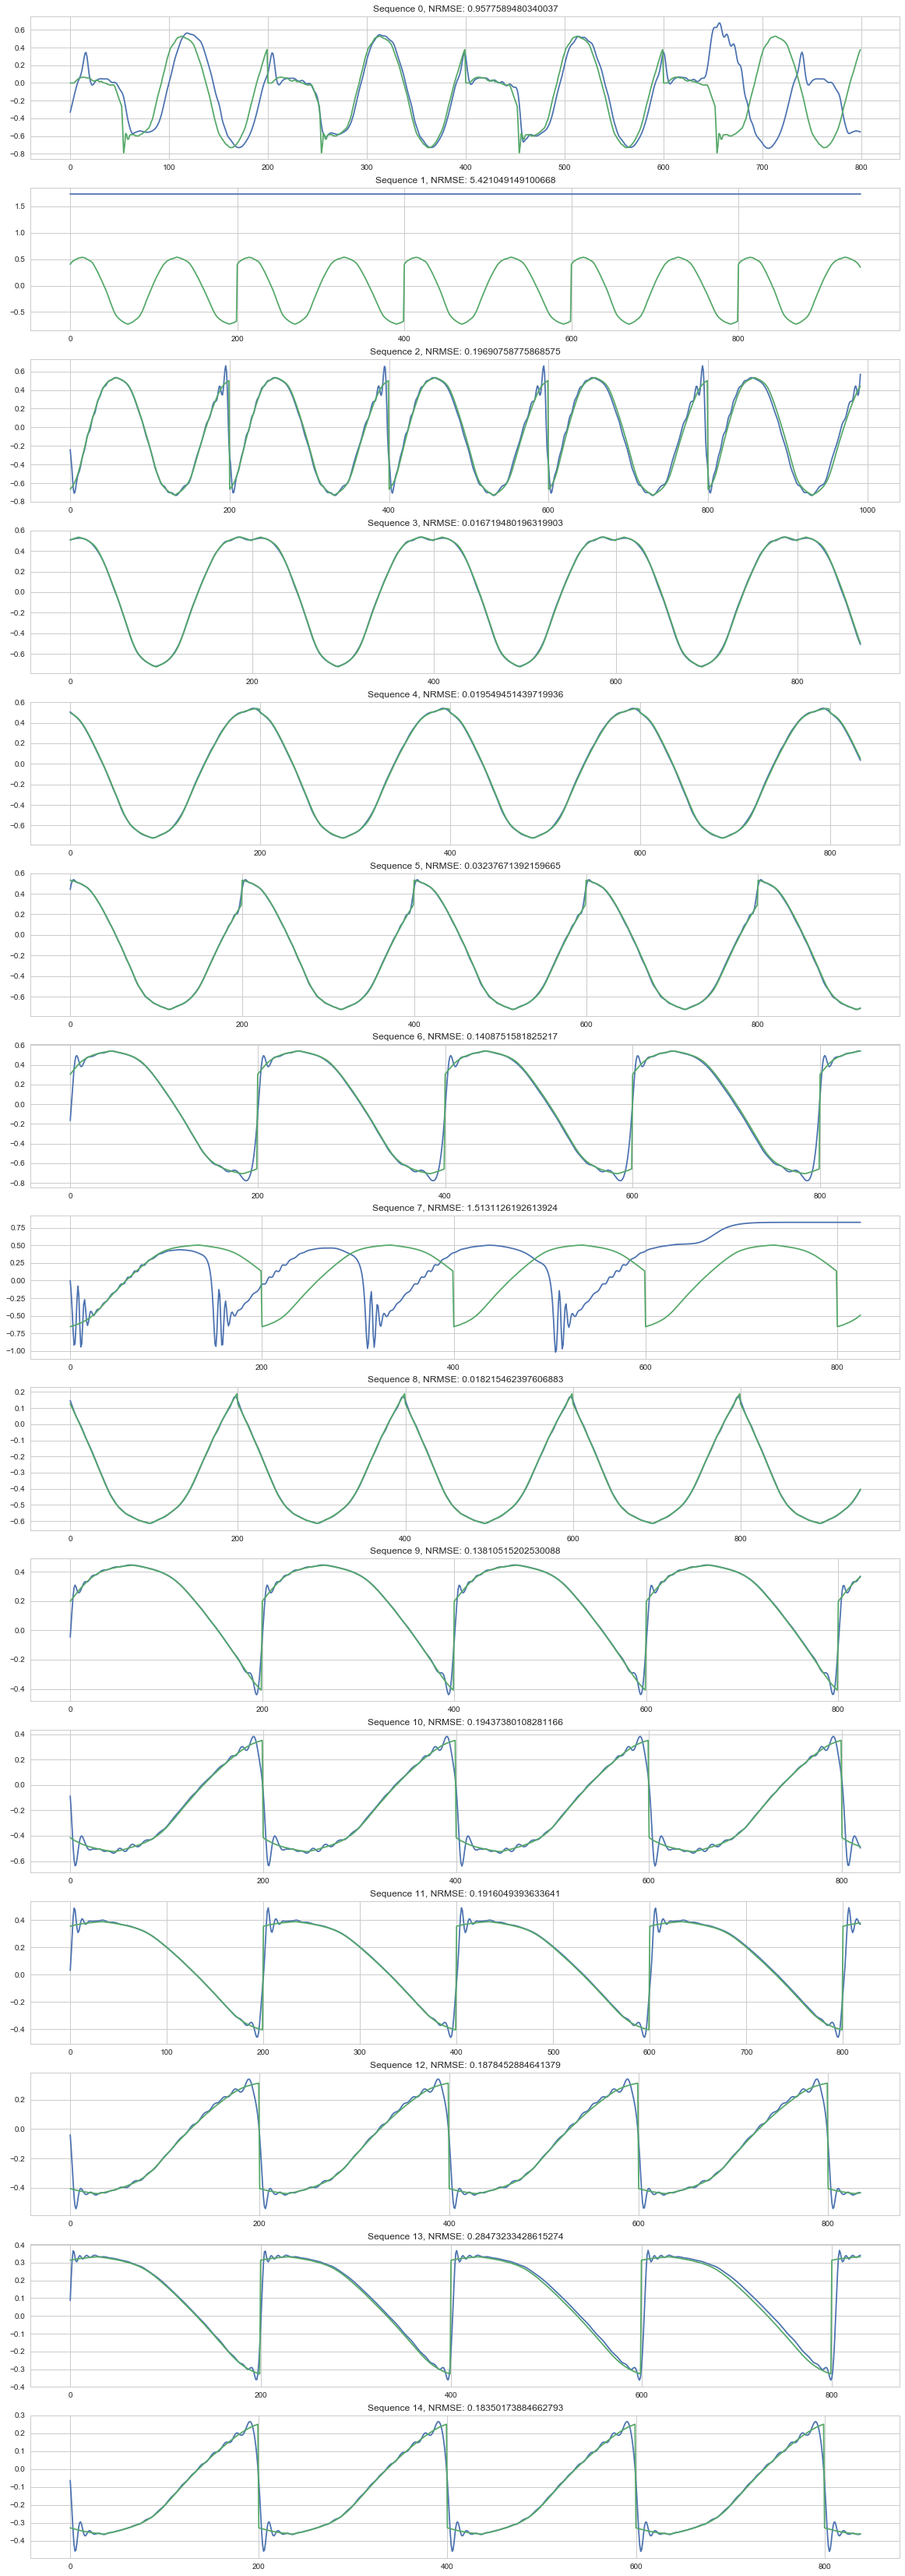

In [33]:
def plotConceptorPattern(net, cs, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    z_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, net['p']['patts'].shape[0]))
    C = cs[0]
    x = 0.5 * np.random.randn(net['p']['N'],1) * 0
    z = x
    for n in range(recallTestLength + net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > net['p']['washoutLength']):
            x_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([net['p']['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:net['p']['patts'][i_pattern].size*2],net['p']['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern)
    plot(targetPattern)
    return score
    
    
figsize(20,60)
patternCs = np.zeros(len(apertures), dtype=np.object)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    print(i_patt)
    ax = subplot(len(apertures), 1, i_patt+1)
    patternCs[i_patt] = computeConceptor(loadedNets[bestNetwork], i_patt, apertures[i_patt])
    scores[i_patt] = plotConceptorPattern(loadedNets[bestNetwork], patternCs[i_patt], windowSize * 5, i_patt)
    ax.set_title("Sequence " + str(i_patt) + ", NRMSE: " + str(scores[i_patt]))
plt.savefig("tmp/tests-909-n500-a30.pdf")

0.6331151882907271
[0.95775895 5.42104915 0.19690759 0.01671948 0.01954945 0.03237671
 0.14087516 1.51311262 0.01821546 0.13810515 0.1943738  0.19160494
 0.18784529 0.28473233 0.18350174]
[0.01671948 0.01821546 0.01954945 0.03237671 0.13810515 0.14087516
 0.18350174 0.18784529 0.19160494 0.1943738  0.19690759 0.28473233
 0.95775895 1.51311262 5.42104915]


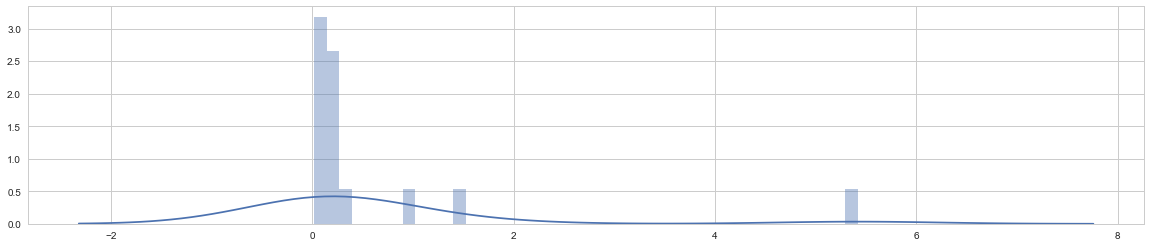

In [34]:
print(np.mean(scores))
print(scores)
figsize(20,4)
# plot(sort(scores))
print(sort(scores))
# print(median(scores))
sns.distplot(scores)
plt.savefig("tmp/scoresDistrib-909-3.pdf")

In [35]:
%%time

def render(net, pcs, lrMod=1.0, cMod=1.0, alphaMod=1.0, speed=1.0, initScale=0.5, initOffset=0.0):
    speed = 1.0/speed
    audio = np.zeros(0)
    x = (initScale * np.random.randn(net['p']['N'],1)) + initOffset
    C = pcs[0][0]
    LR = net['p']['LR'] * lrMod
    orgW = net['W']
    Wmod = orgW * alphaMod
    #run to washout
    for n in range(net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        
   
    for n in range(int(windowSize * pcs.shape[0] * abs(speed))):
        currConceptor = int(n/abs(speed) / windowSize)

        if (speed <= 0):
            currConceptor = pcs.shape[0] - currConceptor - 1  #reverse
        C = pcs[currConceptor][0] * cMod
        xOld = x
        Wtarget = (Wmod.dot(x))
        z = ((1.0 - LR) * xOld) + (LR * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        newSample = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
        audio = np.concatenate((audio, newSample))
    return audio

# audio = render(loadedNets[bestNetwork], patternCs, 1.0, 1.0, 1, 1.0)


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.1 µs


In [36]:
patternCs.shape

(15,)

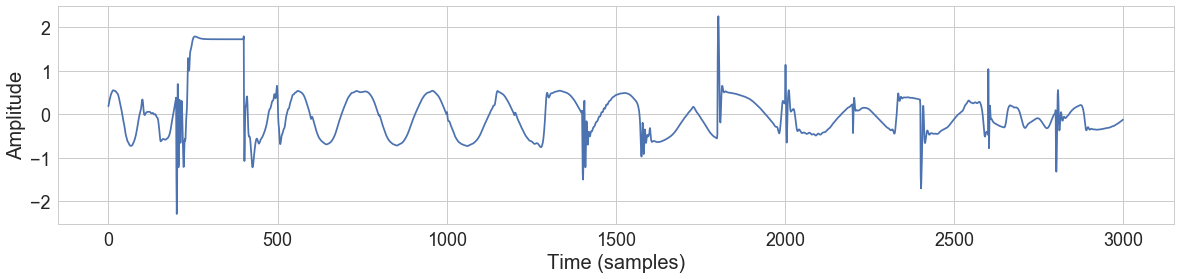

In [42]:

figsize(20,4)
audio = render(loadedNets[bestNetwork], patternCs, 1.0, 1.0, 1, 1.0)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plot(audio)
plt.savefig('/tmp/recon-909-n300-a30.pdf', bbox_inches='tight')
Audio(data=audio,rate=sr)


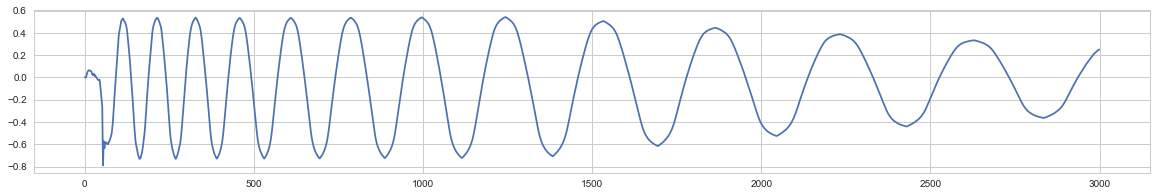

In [39]:
plot(y[:audio.size])
Audio(data=y[:audio.size],rate=sr)


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/output.py:219: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if norm and np.issubdtype(y.dtype, np.float):
/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


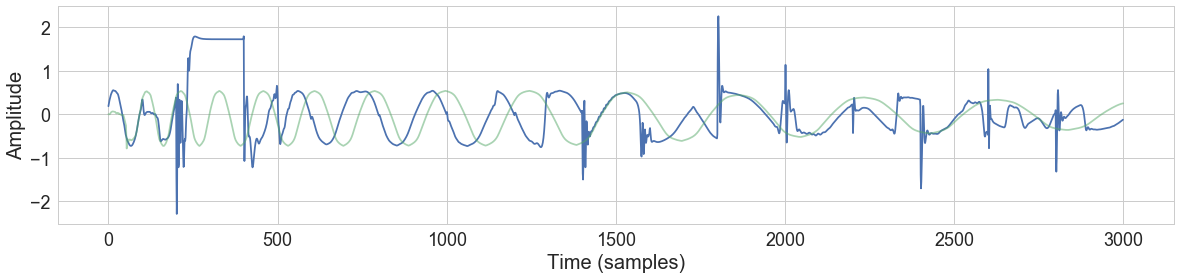

In [46]:
figsize(20,4)
ax=subplot(1,1,1)
plot(audio, alpha=1.0)
plot(y[:audio.size], alpha=0.5)
err = nrmse(audio, y[:audio.size])
# ax.set_title("NRMSE " + str(err))
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.savefig("/tmp/reconCompare-909-n200-a30.pdf", bbox_inches='tight')
librosa.output.write_wav('/tmp/909fail.wav', audio, 22050, norm=True)

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


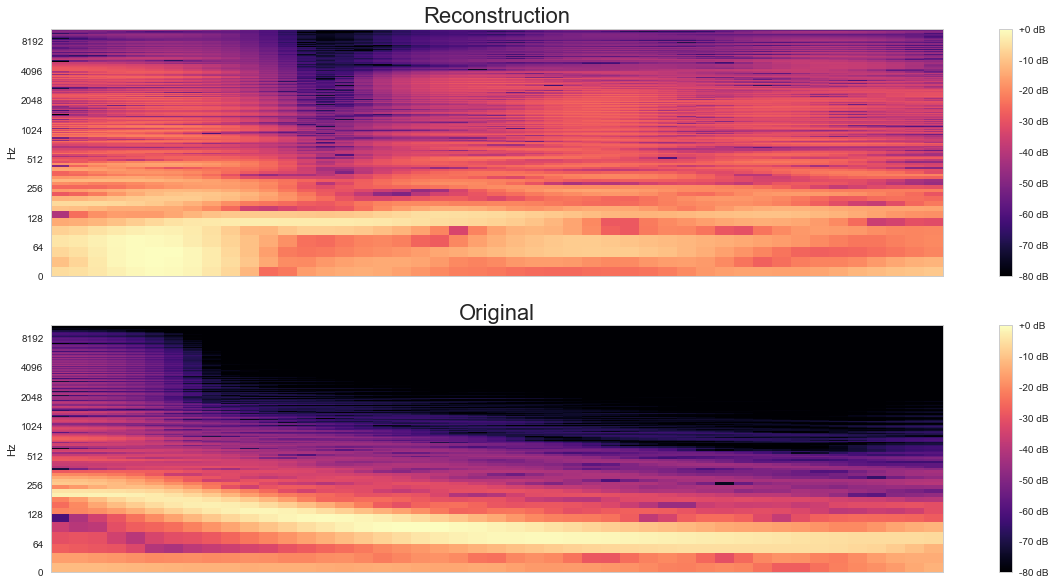

In [47]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[:audio.shape[0]], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig("tmp/expt1Spectra-909-n15-a30.pdf")